In [1]:
%cd ..

/home/feodor/Jupyter/posets


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import networkx as nx

from gudhi import AlphaComplex, SimplexTree
from src.depth import DepthPoset

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time
import itertools
from tqdm.notebook import tqdm

# Define Depth Posets

In [3]:
# sphere as closed cylinder ordered by dimension
delta = np.array([[0, 0, 0, 1, 0, 0, 0, 0], 
                  [0, 0, 0, 1, 0, 0, 0, 0], 
                  [0, 0, 0, 0, 0, 1, 0, 1], 
                  [0, 0, 0, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 0, 0, 0, 1, 1], 
                  [0, 0, 0, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 0, 0, 0, 0, 0]])
dims = np.array([0, 0, 1, 1, 1, 2, 2, 2])

# reorder 
new_order = [0, 2, 1, 3, 4, 7, 6, 5]
delta = delta[new_order][:, new_order]
dims = dims[new_order]

delta, dims

(array([[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]),
 array([0, 1, 0, 1, 1, 2, 2, 2]))

In [4]:
depth_sphere = DepthPoset.from_border_matrix(delta, dims)

In [5]:
n, dim = 12, 3

points = np.random.random([n, dim])

In [6]:

stree = AlphaComplex(points=points).create_simplex_tree()
depth_alpha = DepthPoset.from_simplex_tree(stree)

In [7]:
depth_posets_dict = {'Sphere': depth_sphere, 
                     'Alpha': depth_alpha}#.items()

# Plot Depth Posets

/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


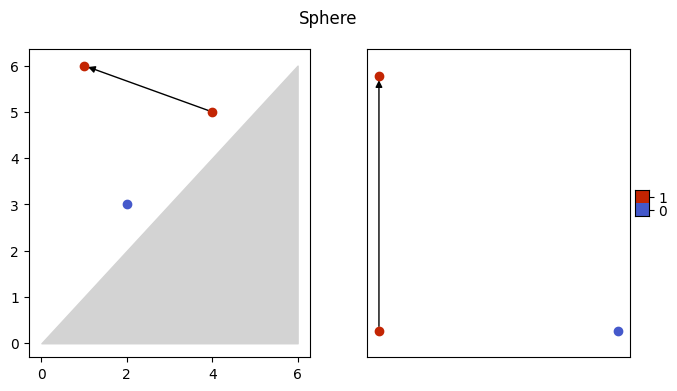

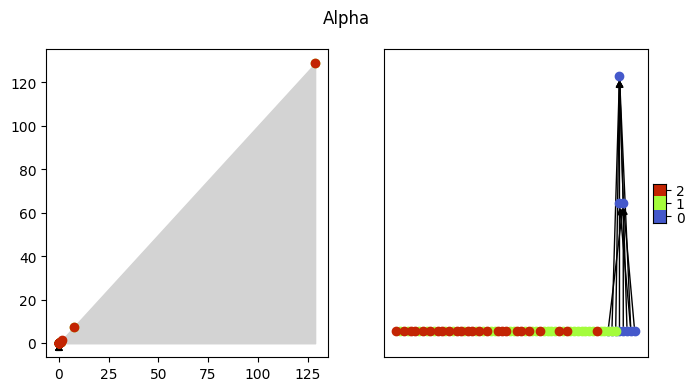

In [8]:
for name, depth in depth_posets_dict.items():
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(name)
    fig.set_figwidth(8)
    fig.set_figheight(4)
    
    colors = cm.turbo(np.linspace(0.1, 0.9, depth.get_dim() + 1))
    for i in range(depth.get_dim() + 1):
        nx.draw_networkx(depth.subposet_dim(i).get_transitive_reduction(), pos=depth.persistant_layout(), node_color=colors[i], node_size=36, 
                         ax=axs[0], with_labels=False, hide_ticks=False)
        nx.draw_networkx(depth.subposet_dim(i).get_transitive_reduction(), pos=depth.hasse_layout(), node_color=colors[i], node_size=36, 
                         ax=axs[1], with_labels=False, hide_ticks=True)
    
    axs[0].fill_between([0, max(depth.get_filtration_values())], 
                        [0, max(depth.get_filtration_values())], 
                        [0, 0], color='lightgrey')
    
    divider = make_axes_locatable(axs[-1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    cax.imshow([[col] for col in colors], origin='lower')
    cax.yaxis.tick_right()
    cax.set_yticks(np.arange(len(colors)))
    cax.set_xticks([])
    
    plt.show()

# Poset Statistics for Depth Poset

In [9]:
from src import poset_scores

In [10]:
scores = [poset_scores.number_of_nodes, 
          poset_scores.number_of_minimal_nodes, 
          poset_scores.number_of_maximal_nodes, 
          poset_scores.number_of_edges_in_reduction, 
          poset_scores.number_of_edges_in_closure, 
          poset_scores.height, 
          poset_scores.width, 
          poset_scores.avarage_maximal_chain,
          poset_scores.minimum_maximal_chain
         ]

In [11]:
df = []
for name, score in itertools.product(depth_posets_dict, scores):
    depth = depth_posets_dict[name]
    row = {'complex': name, 
           'score' : score.__name__}
    score_timer = time.perf_counter()
    score_value = score(depth)
    score_timer = time.perf_counter() - score_timer
    row.update({'value full': score_value, 
                'time full': score_timer})
    for dim in range(depth.get_dim() + 1):
        score_timer = time.perf_counter()
        score_value = score(depth.subposet_dim(dim))
        score_timer = time.perf_counter() - score_timer
        row.update({f'value dim={dim}': score_value, 
                    f'time dim={dim}': score_timer})
    df.append(row)
df = pd.DataFrame(df)
df

,complex,score,value full,time full,value dim=0,time dim=0,value dim=1,time dim=1,value dim=2,time dim=2
0,Sphere,number_of_nodes,3.000000,0.000005,1.000000,0.000121,2.0,0.000187,NaN,NaN
1,Sphere,number_of_minimal_nodes,2.000000,0.000008,1.000000,0.000056,1.0,0.000169,NaN,NaN
2,Sphere,number_of_maximal_nodes,2.000000,0.000006,1.000000,0.000048,1.0,0.000418,NaN,NaN
3,Sphere,number_of_edges_in_reduction,1.000000,0.000086,0.000000,0.000076,1.0,0.000213,NaN,NaN
4,Sphere,number_of_edges_in_closure,1.000000,0.000105,0.000000,0.000090,1.0,0.000239,NaN,NaN
5,Sphere,height,1.000000,0.000665,0.000000,0.000112,1.0,0.000263,NaN,NaN
6,Sphere,width,2.000000,0.000651,1.000000,0.000115,1.0,0.000444,NaN,NaN
7,Sphere,avarage_maximal_chain,1.500000,0.001266,1.000000,0.000170,2.0,0.000494,NaN,NaN
8,Sphere,minimum_maximal_chain,1.000000,0.000362,1.000000,0.000184,2.0,0.000366,NaN,NaN
9,Alpha,number_of_nodes,70.000000,0.000002,11.000000,0.000581,34.0,0.000214,25.0,0.000128


# Node Statistics for depth posets

In [12]:
from src import node_scores

In [13]:
scores = [node_scores.incestors_number, 
          node_scores.successors_number, 
          node_scores.incomparable_number, 
          node_scores.incestors_height, 
          node_scores.successors_height, 
          node_scores.incestors_width, 
          node_scores.successors_width, 
          
]


In [14]:
df = []
with tqdm(total=len(depth_posets_dict)*len(scores)) as pbar:
    for name, score in itertools.product(depth_posets_dict, scores):
        pbar.set_postfix_str(f'complex={name}, score={score.__name__}')
        pbar.refresh()
        depth = depth_posets_dict[name]
        row = {'complex': name, 
               'score' : score.__name__}
        score_timer = time.perf_counter()
        score_value = [score(depth, node) for node in depth.nodes]
        score_timer = time.perf_counter() - score_timer
        row.update({'min value full': np.min(score_value), 
                    'max value full': np.max(score_value), 
                    'avg value full': np.mean(score_value), 
                    'time full': score_timer})
        for dim in range(depth.get_dim() + 1):
            pbar.set_postfix_str(f'complex={name}, score={score.__name__}, dim={dim}')
            pbar.refresh()
            score_timer = time.perf_counter()
            subdepth = depth.subposet_dim(dim)
            score_value = [score(subdepth, node) for node in subdepth.nodes]
            score_timer = time.perf_counter() - score_timer
            row.update({f'min value dim={dim}': np.min(score_value), 
                        f'max value dim={dim}': np.max(score_value), 
                        f'avg value dim={dim}': np.mean(score_value), 
                        f'time dim={dim}': score_timer})
        df.append(row)
        pbar.update()
df = pd.DataFrame(df)
df[np.concatenate([['complex', 'score'], df.columns[df.columns.str.contains('value')]])]

  0%|          | 0/14 [00:00<?, ?it/s]

,complex,score,min value full,max value full,avg value full,min value dim=0,max value dim=0,avg value dim=0,min value dim=1,max value dim=1,avg value dim=1,min value dim=2,max value dim=2,avg value dim=2
0,Sphere,incestors_number,0,1,0.333333,0,0,0.000000,0,1,0.5,NaN,NaN,NaN
1,Sphere,successors_number,0,1,0.333333,0,0,0.000000,0,1,0.5,NaN,NaN,NaN
2,Sphere,incomparable_number,1,2,1.333333,0,0,0.000000,0,0,0.0,NaN,NaN,NaN
3,Sphere,incestors_height,0,0,0.000000,0,0,0.000000,0,0,0.0,NaN,NaN,NaN
4,Sphere,successors_height,0,0,0.000000,0,0,0.000000,0,0,0.0,NaN,NaN,NaN
5,Sphere,incestors_width,0,1,0.333333,0,0,0.000000,0,1,0.5,NaN,NaN,NaN
6,Sphere,successors_width,0,1,0.333333,0,0,0.000000,0,1,0.5,NaN,NaN,NaN
7,Alpha,incestors_number,0,2,0.185714,0,2,1.181818,0,0,0.0,0.0,0.0,0.0
8,Alpha,successors_number,0,9,0.185714,0,9,1.181818,0,0,0.0,0.0,0.0,0.0
9,Alpha,incomparable_number,60,69,68.628571,1,9,7.636364,33,33,33.0,24.0,24.0,24.0


In [15]:
df[np.concatenate([['complex', 'score'], df.columns[df.columns.str.contains('time')]])]

,complex,score,time full,time dim=0,time dim=1,time dim=2
0,Sphere,incestors_number,0.000894,0.000104,0.000826,NaN
1,Sphere,successors_number,0.000813,0.000123,0.000649,NaN
2,Sphere,incomparable_number,0.000526,0.000070,0.001117,NaN
3,Sphere,incestors_height,0.001485,0.000190,0.000848,NaN
4,Sphere,successors_height,0.001496,0.000294,0.000908,NaN
5,Sphere,incestors_width,0.001646,0.000206,0.000957,NaN
6,Sphere,successors_width,0.001443,0.000175,0.001035,NaN
7,Alpha,incestors_number,2.448578,0.044102,0.117052,0.051839
8,Alpha,successors_number,2.375290,0.045453,0.117145,0.052760
9,Alpha,incomparable_number,1.761631,0.024896,0.070237,0.030877


# Save and load

In [16]:
import os
import pickle as pkl

In [17]:
test_poset = depth_alpha
test_path = "test-poset.pkl"

In [18]:
# save test file
with open(test_path, "wb") as file:
    pkl.dump(test_poset, file)

# load test file
with open(test_path, "rb") as file:
    test_poset_loaded = pkl.load(file)

# remove this test file
if os.path.exists(test_path):
    os.remove(test_path)

In [19]:
assert len(test_poset.nodes) == len(test_poset_loaded.nodes)  
for i in range(len(test_poset.nodes)):
    assert test_poset.nodes == test_poset_loaded.nodes

assert len(test_poset.edges) == len(test_poset_loaded.edges)  
for i in range(len(test_poset.edges)):
    assert test_poset.edges == test_poset_loaded.edges